# Attention with Saliency and Class Activation Map

This notebook explain how to get various attention images with Saliency, SmoothGrad, GradCAM, GradCAM++ and ScoreCAM/Faster-ScoreCAM.

## Preparation

### Install libraries

At first, when you didn't yet installed `tf-keras-vis` in your environment such Google Colab, please run the cell below.

In [13]:
#pip install --upgrade tf-keras-vis tensorflow matplotlib
#https://github.com/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb

### Load libraries

In [10]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('{} GPUs'.format(gpus))

0 GPUs


### Load tf.keras.Model

This example notebook uses VGG16 model in tf.keras, but if you want to use other tf.keras.Model, you can do so by modifing the section below.

In [2]:
from keras.models import load_model
DenseNet=load_model("DenseNet-Binary.h5")
DenseNet.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

### Load images

tf-keras-vis support evaluating batch-wisely that includes multiple images. Here, we load three pictures of goldfish, bear and assault-rifle as inputs data.

In [5]:
img_path1 = "E:\\Uni\\data2\\code\\input\\DataFinal\\train\\covid\\COVID19_164_.jpeg"
img_path2 = "E:\\Uni\\data2\\code\\input\\DataFinal\\train\\normal\\NORMAL_32_.jpeg"

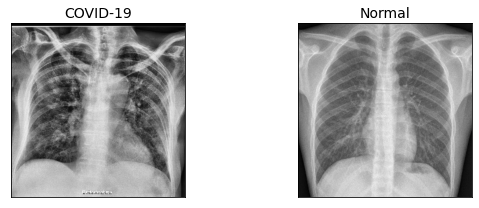

In [6]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

# Image titles
image_titles = ['COVID-19', 'Normal']
# Load images
img1 = load_img(img_path1,target_size=(300, 300))
img2 = load_img(img_path2,target_size=(300, 300))
images = np.asarray([np.array(img1), np.array(img2)])

# Preparing input data
X = preprocess_input(images)

# Rendering
subplot_args = { 'nrows': 1, 'ncols': 2, 'figsize': (9, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
plt.tight_layout()
plt.show()

## Define necessary functions

### Define Loss functions

You MUST define `loss` function that return target scores.

In [7]:
# The `output` variable refer to the output of the model,
# so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
def loss2(output):
    # 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
    return (output[0][0], output[1][0])

### Define Model-Modifier function

Then, when the softmax activation function is applied to the last layer of model, it may obstruct generating the attention images, so you need to replace the function to a linear function. Here, we does so using `model_modifier`.

In [8]:
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

## GradCAM

Saliency is one of useful way of visualizing attention that appears input regions that a change in the input value contribute the output value.
GradCAM is another way of visualizing attention over input. Instead of using gradients with respect to model outputs, it uses penultimate (pre Dense layer) Conv layer output.

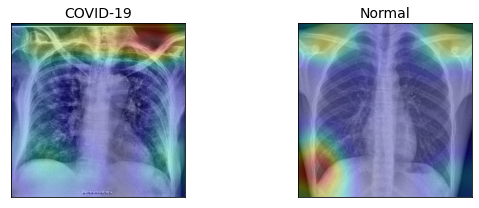

Wall time: 1.8 s


In [14]:
%%time

def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(DenseNet,
                  model_modifier=model_modifier,
                  clone=False)

# Generate heatmap with GradCAM}
cam = gradcam(loss2,
              X,
              penultimate_layer=-1, # model.layers number
             )
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.3) # overlay
plt.tight_layout()
plt.show()

As you can see above, GradCAM is useful method for intuitively knowing where the attention is. But when you take a look closely, especially the head of Bear, you'll see that the visualized attentions don't completely cover the target objects that appear in the picture.

Okay then, let's move on to next algrism that is able to imporove the ploblem above you looked.

## ScoreCAM

Lastly, Here, we show you ScoreCAM. SocreCAM is an another method that generate Class Activation Map. The characteristic is that it's the `gradient-free` CAM method unlike GradCAM/GradCAM++.

In default, this method takes too much time, so in the cell below ScoreCAM is NOT run with CPU.

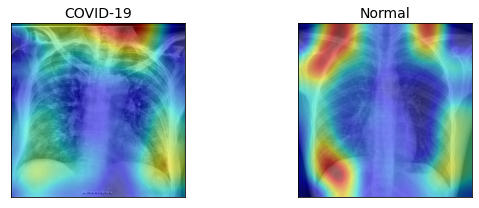

Wall time: 17.8 s


In [19]:
%%time

from tf_keras_vis.scorecam import ScoreCAM

# Create ScoreCAM object
scorecam = ScoreCAM(DenseNet, model_modifier, clone=False)

# This cell takes toooooooo much time, so only doing with GPU.
if gpus == 0:
    # Generate heatmap with ScoreCAM
    cam = scorecam(loss2,
                   X,
                   penultimate_layer=-1, # model.layers number
                  )
    cam = normalize(cam)

    f, ax = plt.subplots(**subplot_args)
    for i, title in enumerate(image_titles):
        heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
        ax[i].set_title(title, fontsize=14)
        ax[i].imshow(images[i])
        ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("Let's run a next cell to show Faster-ScoreCAM")

## Faster-ScoreCAM

As you see above, ScoreCAM need huge processing power, but there is a good news for us. Faster-ScorecAM that makes ScoreCAM to be more efficient was devised by @tabayashi0117.

https://github.com/tabayashi0117/Score-CAM/blob/master/README.md#faster-score-cam
> We thought that several channels were dominant in generating the final heat map. Faster-Score-CAM adds the processing of “use only channels with large variances as mask images” to Score-CAM. (max_N = -1 is the original Score-CAM).


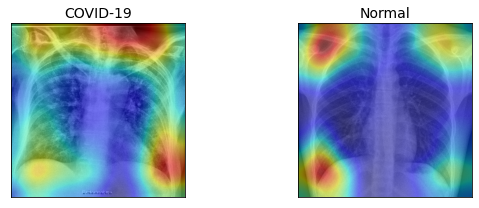

Wall time: 9.47 s


In [20]:
%%time

# Create ScoreCAM object
scorecam = ScoreCAM(DenseNet, model_modifier, clone=False)

# Generate heatmap with Faster-ScoreCAM
cam = scorecam(loss2,
               X,
               penultimate_layer=-1, # model.layers number
               max_N=10
              )
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
plt.tight_layout()
plt.savefig("DenseNet Fast-ScoreCam.png")
plt.show()